In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
# ^^^ pyforest auto-imports - don't write above this line
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import h5py

In [5]:
model_name="unet"#"fcn"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50

In [6]:
"""def to_categorical(y, num_classes):
    return np.eye(num_classes, dtype='uint8')[y]"""

"def to_categorical(y, num_classes):\n    return np.eye(num_classes, dtype='uint8')[y]"

In [9]:
class SimDataset(Dataset):
    def __init__(self, train=True):
        if model_name == "fcn":
            dataset = h5py.File(r'\training\fc_data\data_2D_size_224_224_res_1.36719_1.36719.hdf5','r')
        elif model_name == "unet":
            dataset = h5py.File(r'D:\Work\Med Proj\training\unet_data\data_2D_size_212_212_res_1.36719_1.36719.hdf5','r')
        
        if train:
            self.input_images, self.target_masks = dataset['images_train'],dataset['masks_train']
        else:
            self.input_images, self.target_masks = dataset['images_test'],dataset['masks_test']

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        mask[mask == 1] = 0
        mask[mask == 2] = 0
        mask[mask == 3] = 1
        
        if model_name == "unet":
            x = np.zeros((1,212, 212))
        elif model_name == "fcn":
            x = np.zeros((1,224, 224))
        x[0,:image.shape[0], :image.shape[1]] = image
        
        #m=np.zeros((2,224,224))
        """k=to_categorical(mask,2)
        print(np.rollaxis(k,-1).shape)"""
        #m[:,:mask.shape[0], :mask.shape[1]] = np.rollaxis(to_categorical(mask,2),-1)
        return [torch.Tensor(x), torch.Tensor(mask).unsqueeze(0)]

In [10]:
train_set = SimDataset(True)
val_set = SimDataset(False)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 8
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [11]:
inputs, masks = next(iter(dataloaders['train']))

In [12]:
print(inputs.shape, masks.shape)

torch.Size([8, 1, 212, 212]) torch.Size([8, 1, 212, 212])


In [13]:
if model_name == "unet":
    import modified_ap3net_model
    model = modified_ap3net_model.Unet()
elif model_name == "fcn":
    import Fully_Connected_Network
    model = Fully_Connected_Network.FC()

In [14]:
model = model.to(device)

In [15]:
# check keras-like model summary using torchsummary
from torchsummary import summary
if model_name == "fcn":
    summary(model, input_size=(1, 224, 224))
elif model_name == "unet":
    summary(model, input_size=(1, 212, 212))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 396, 396]               0
            Conv2d-2         [-1, 64, 394, 394]             640
              ReLU-3         [-1, 64, 394, 394]               0
            Conv2d-4         [-1, 64, 392, 392]          36,928
              ReLU-5         [-1, 64, 392, 392]               0
         MaxPool2d-6         [-1, 64, 196, 196]               0
            Conv2d-7        [-1, 128, 194, 194]          73,856
              ReLU-8        [-1, 128, 194, 194]               0
            Conv2d-9        [-1, 128, 192, 192]         147,584
             ReLU-10        [-1, 128, 192, 192]               0
        MaxPool2d-11          [-1, 128, 96, 96]               0
           Conv2d-12          [-1, 256, 94, 94]         295,168
             ReLU-13          [-1, 256, 94, 94]               0
           Conv2d-14          [-1, 256,

In [16]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [17]:
validation_loss = []
trains_loss = []

In [18]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
    
    if phase == "train":
        trains_loss.append(outputs)
    else:
        validation_loss.append(outputs)
    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        since = time.time()
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            metrics = defaultdict(float)
            epoch_samples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                epoch_samples += inputs.size(0)
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

cuda:0
Epoch 0/49
----------
LR 0.0001


D:\Anaconda3\envs\python36\lib\site-packages\torch\optim\lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
D:\Anaconda3\envs\python36\lib\site-packages\torch\nn\functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


KeyboardInterrupt: 

In [15]:
#train values
diceT= []
bceT = []
lossT = []
accT = []
dice_accT = []
for i in range(num_epochs):
    bceT.append(float(trains_loss[i][0][5:]))
    diceT.append(float(trains_loss[i][1][6:]))
    lossT.append(float(trains_loss[i][2][6:]))
    accT.append(1-float(trains_loss[i][2][6:]))
    dice_accT.append(1-float(trains_loss[i][1][6:]))

In [16]:
#train values
diceV= []
bceV = []
lossV = []
accV = []
dice_accV = []
for i in range(num_epochs):
    bceV.append(float(validation_loss[i][0][5:]))
    diceV.append(float(validation_loss[i][1][6:]))
    lossV.append(float(validation_loss[i][2][6:]))
    accV.append(1-float(validation_loss[i][2][6:]))
    dice_accV.append(1-float(validation_loss[i][1][6:]))

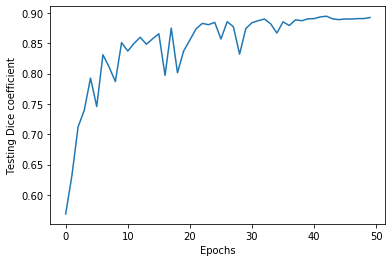

In [28]:
import matplotlib.pyplot as plt
plt.plot(dice_accV)
plt.xlabel("Epochs")
plt.ylabel("Testing Dice coefficient")
plt.show()

In [29]:
torch.save(model.state_dict(), r"model_unet.pth")

torch.Size([1, 224, 224])
(1, 1, 224, 224)
(50176, 1)


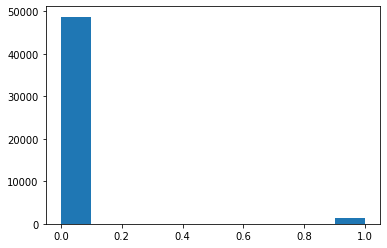

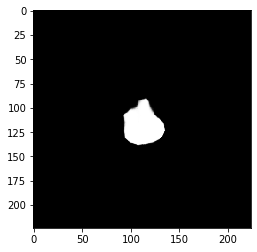

In [16]:
"""#device = torch.device('cpu')
model = modified_ap3net_model.Unet()
model.load_state_dict(torch.load("model.pth", map_location=device))

import math

model.eval()   # Set model to the evaluation mode

# Create another simulation dataset for test
test_dataset = SimDataset(False)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=4)

# Get the first batch
inputs, labels = next(iter(test_dataset))
print(inputs.shape)
inputs = torch.unsqueeze(inputs, 0)
labels = torch.unsqueeze(labels, 0)
inputs = inputs.to(device)
labels = labels.to(device)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

print(pred.reshape((224 *224, -1)).shape)
plt.hist(pred.reshape((224*224, -1)))
plt.figure()
plt.imshow(255 * pred.reshape((224,224)), cmap = 'gray')
# Change channel-order and make 3 channels for matplot
#input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
#target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
#pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

#helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])"""

In [ ]:
"""inputs, masks = next(iter(dataloaders['val']))
print(inputs.shape)"""